In [1]:
from model import Model

model = Model()

model.eval()

/home/nisarg/anaconda3/envs/sd_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Model(
  (feature_extractor): EfficientNetFeatures(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (

In [3]:
import torch
from cityscapes import CityscapesDataModule

dm = CityscapesDataModule()
dm.setup()

In [30]:
confusion_matrix = torch.zeros(19, 19, dtype=torch.int64)

for batch in dm.val_dataloader():
    masks = batch[1]
    masks = masks[masks != 255]
    # print(torch.unique(masks))
    confusion_matrix += torch.bincount(19 * masks, minlength=19**2).view(19, 19)
    # break

In [31]:
confusion_matrix.sum(dim=1) / confusion_matrix.sum()

tensor([0.3795, 0.0540, 0.2135, 0.0070, 0.0083, 0.0149, 0.0020, 0.0067, 0.1744,
        0.0084, 0.0340, 0.0131, 0.0022, 0.0659, 0.0030, 0.0039, 0.0011, 0.0008,
        0.0072])

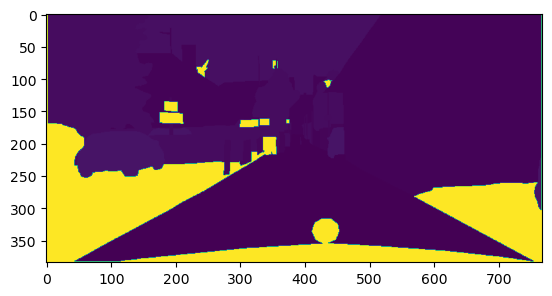

In [22]:
import matplotlib.pyplot as plt

plt.imshow(batch[1][0])

In [20]:
masks.shape

torch.Size([235583])